In [1]:
import os
import json
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
import helpers as ph
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
sns.set_style('whitegrid')
styles = ph.VIS_STYLES

/Users/carolina.oguchi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
RESULTS_DIR = f'./data/distributions/'
CONTEXT = 'default'
SAVEFIG = True

## Load human and LM opinion distributions

In [3]:
combined_df = []
for wave in ph.PEW_SURVEY_LIST:
    SURVEY_NAME = f'American_Trends_Panel_W{wave}'
    cdf = pd.read_csv(os.path.join(RESULTS_DIR, f'{SURVEY_NAME}_{CONTEXT}_combined.csv'))
    cdf['survey'] = f'ATP {wave}'
    combined_df.append(cdf)
combined_df = pd.concat(combined_df)
combined_df['Source'] = combined_df.apply(lambda x: 'AI21 Labs' if 'j1-' in x['model_name'].lower() else 'OpenAI',
                                          axis=1)

## Compute average representativeness across dataset

In [4]:
KEYS = ['model_name', 'attribute', 'group', 'group_order', 'model_order']

grouped = combined_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \
         .sort_values(by=['model_order', 'group_order'])
grouped['Rep'] = 1 - grouped['WD']

/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/626076768.py:3: FutureWarning: The provided callable <function mean at 0x10347d430> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped = combined_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \


## Load coarse/fine-grained topics

In [5]:
topic_info = np.load('./data/human_resp/topic_mapping.npy', allow_pickle=True).item()

In [6]:
combined_df['topic_cg'] = combined_df.apply(lambda x: topic_info[x['question']]['cg'], axis=1)
combined_df['topic_fg'] = combined_df.apply(lambda x: topic_info[x['question']]['fg'], axis=1)

## Measure topic-level consistency

In [7]:
MD_TO_PALETTE = {'POLIDEOLOGY': 'coolwarm_r',
                 'EDUCATION': 'PuBuGn',
                 'INCOME': 'YlGnBu'}

### Coarse grained

In [8]:
topic_df = combined_df.explode(['topic_cg']).rename(columns={'topic_cg': 'topic'})

KEYS = ['model_name', 'attribute', 'group', 'group_order', 'model_order', 'topic']

topic_df = topic_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \
         .sort_values(by=['model_order', 'group_order'])
topic_df['Rep'] = 1 - topic_df['WD']

/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/2988082906.py:5: FutureWarning: The provided callable <function mean at 0x10347d430> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  topic_df = topic_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \


/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/3418714527.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/3418714527.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/3418714527.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/3418714527.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

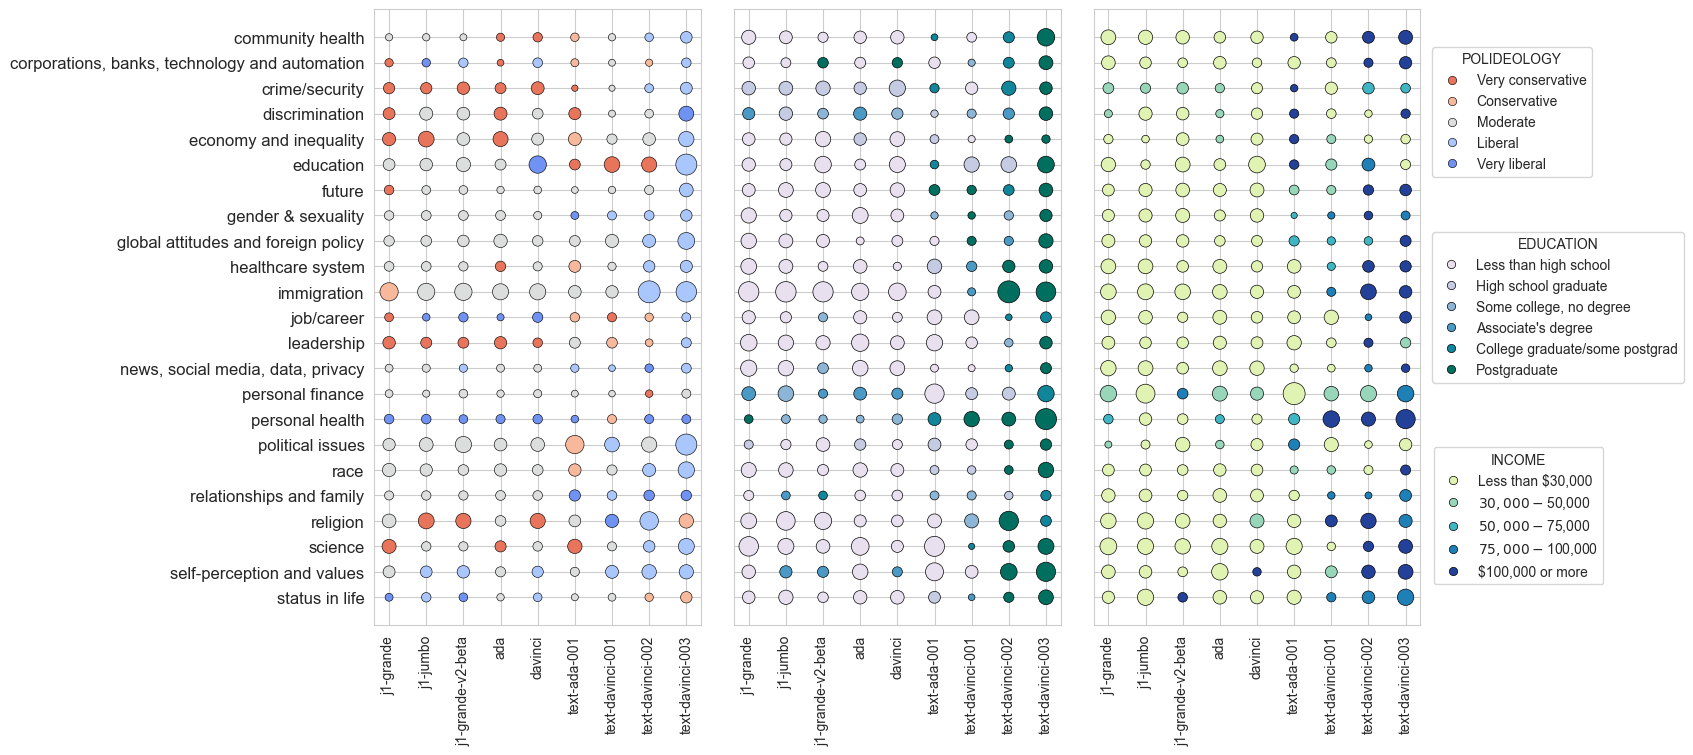

In [10]:
MDS = ['POLIDEOLOGY', 'EDUCATION', 'INCOME']
offsets = [1.22, 1.25, 1.225]
fig, axarr = plt.subplots(1, len(MDS), figsize=(len(MDS)*4.5, 8), 
                          sharey=True)


for mdi, MD in enumerate(MDS):

    tdf = topic_df[topic_df['attribute'] == MD].sort_values(by='Rep')


    size_df = tdf.groupby(['model_order', 'model_name', 'topic', 'attribute'], as_index=False)\
                    .agg({'Rep': list})
    size_df['ratio'] = size_df.apply(lambda x: max(x['Rep']) / min(x['Rep']), axis=1)
    size_df = size_df.drop(columns={'Rep'})

    match_df = tdf.groupby(['model_order', 'model_name', 'topic', 'attribute'], 
                           as_index=False).last()

    match_df = pd.merge(match_df, size_df)\
                .sort_values(by=['topic', 'model_order', 'group_order'])

    group_list = match_df[['group_order', 'group']].drop_duplicates() \
              .sort_values(by='group_order')['group'].values
    palette = MD_TO_PALETTE[MD]

    group_to_order = {o: oi for oi, o in enumerate(group_list)}
    group_to_color = {o: c for o, c in zip(group_list, 
                                           sns.color_palette(palette, len(group_list)))}


    ax = axarr[mdi]
    sns.scatterplot(data=match_df, y='topic', x='model_name', hue='group', 
                    size='ratio',
                    palette=group_to_color, ax=ax, sizes=(20, 250), edgecolor='black')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if mdi == 0:
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
        
    ax.legend(title=MD, ncol=1, loc="upper center", 
              bbox_to_anchor=(0.5, offsets[mdi]+0.5))
    
    h, l = ax.get_legend_handles_labels()
    h, l = np.array(h), np.array(l)    
    lvalid = [li for li, ll in enumerate(l) if ll in group_list]
    h, l = h[lvalid], l[lvalid]
    lidx = np.argsort([group_to_order[ll] for ll in l])
    locs = [[3.48, 0.95],
            [2.52, 0.65],
            [1.3, 0.3]]
    ax.legend(h[lidx], l[lidx], title=MD, ncol=1, loc="upper center", bbox_to_anchor=locs[mdi])
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
plt.subplots_adjust(wspace=0.1)
#if SAVEFIG: plt.savefig('./figures/consistency_cg.png', bbox_inches="tight")
plt.show()

### Fine-grained

In [11]:
topic_fg_df = combined_df.explode(['topic_fg']).rename(columns={'topic_fg': 'topic'})

KEYS = ['model_name', 'attribute', 'group', 'group_order', 'model_order', 'topic']

topic_fg_df = topic_fg_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \
         .sort_values(by=['model_order', 'group_order'])
topic_fg_df['Rep'] = 1 - topic_fg_df['WD']

/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/4243747241.py:5: FutureWarning: The provided callable <function mean at 0x10347d430> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  topic_fg_df = topic_fg_df.groupby(KEYS, as_index=False).agg({'WD': np.mean}) \


/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/2307266598.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/2307266598.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/2307266598.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/2307266598.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

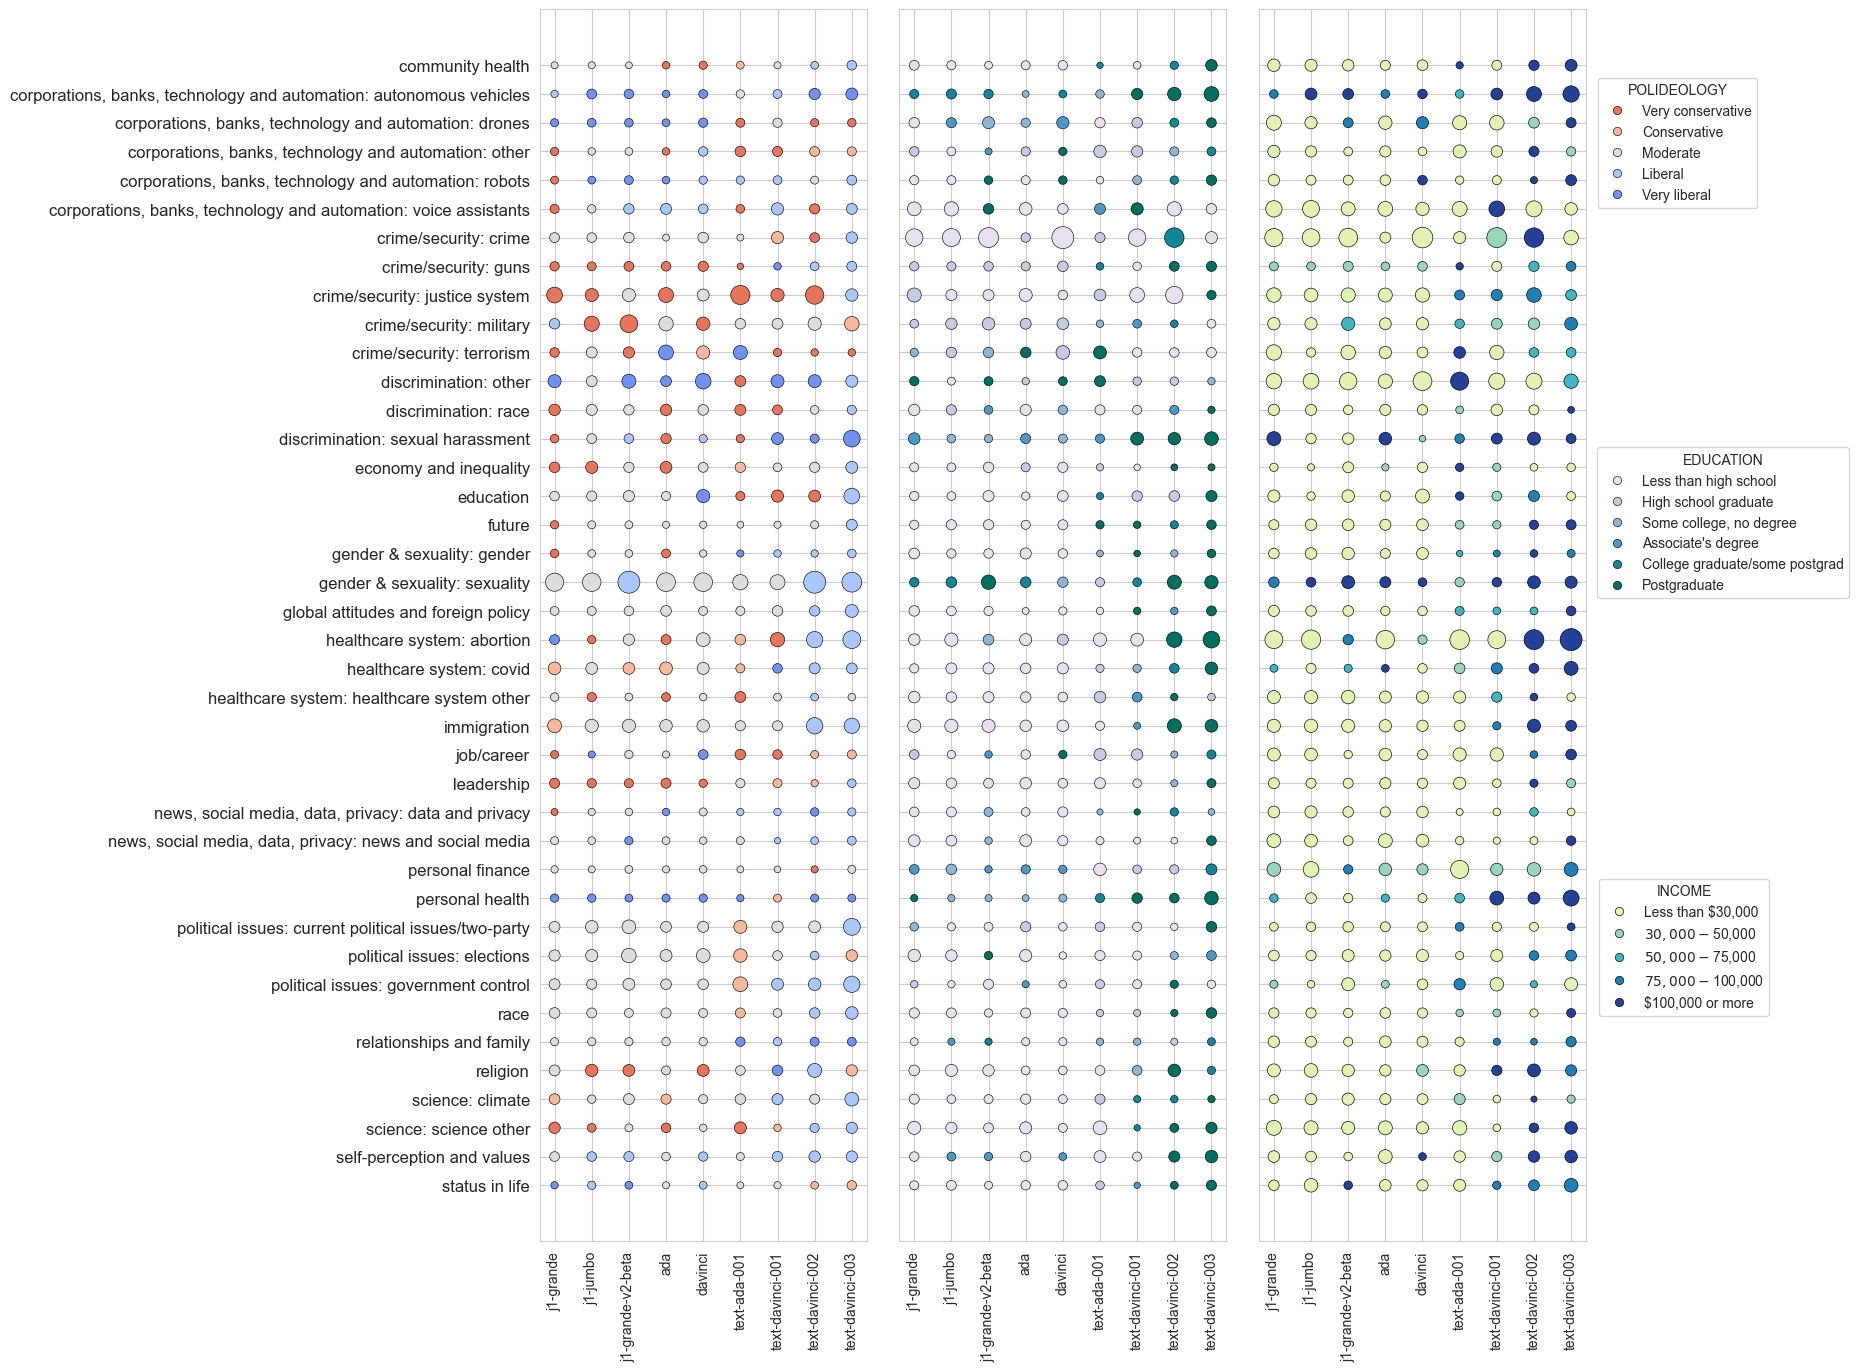

In [12]:
MDS = ['POLIDEOLOGY', 'EDUCATION', 'INCOME']
offsets = [1.22, 1.25, 1.225]
fig, axarr = plt.subplots(1, len(MDS), figsize=(len(MDS)*4.5, 16), 
                          sharey=True)


for mdi, MD in enumerate(MDS):

    tdf = topic_fg_df[topic_fg_df['attribute'] == MD].sort_values(by='Rep')


    size_df = tdf.groupby(['model_order', 'model_name', 'topic', 'attribute'], as_index=False)\
                    .agg({'Rep': list})
    size_df['ratio'] = size_df.apply(lambda x: max(x['Rep']) / min(x['Rep']), axis=1)
    size_df = size_df.drop(columns={'Rep'})

    match_df = tdf.groupby(['model_order', 'model_name', 'topic', 'attribute'], 
                           as_index=False).last()

    match_df = pd.merge(match_df, size_df)\
                .sort_values(by=['topic', 'model_order', 'group_order'])

    group_list = match_df[['group_order', 'group']].drop_duplicates() \
              .sort_values(by='group_order')['group'].values
    palette = MD_TO_PALETTE[MD]

    group_to_order = {o: oi for oi, o in enumerate(group_list)}
    group_to_color = {o: c for o, c in zip(group_list, 
                                           sns.color_palette(palette, len(group_list)))}


    ax = axarr[mdi]
    sns.scatterplot(data=match_df, y='topic', x='model_name', hue='group', 
                    size='ratio',
                    palette=group_to_color, ax=ax, sizes=(20, 250), edgecolor='black')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if mdi == 0:
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
        
    ax.legend(title=MD, ncol=1, loc="upper center", 
              bbox_to_anchor=(0.5, offsets[mdi]+0.5))
    
    h, l = ax.get_legend_handles_labels()
    h, l = np.array(h), np.array(l)    
    lvalid = [li for li, ll in enumerate(l) if ll in group_list]
    h, l = h[lvalid], l[lvalid]
    lidx = np.argsort([group_to_order[ll] for ll in l])
    locs = [[3.48, 0.95],
            [2.52, 0.65],
            [1.3, 0.3]]
    ax.legend(h[lidx], l[lidx], title=MD, ncol=1, loc="upper center", bbox_to_anchor=locs[mdi])
    
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
plt.subplots_adjust(wspace=0.1)
#if SAVEFIG: plt.savefig('./figures/consistency_fg.png', bbox_inches="tight")
plt.show()

## Table

In [13]:
KEYS = ['model_name', 'attribute', 'model_order']

best_overall = grouped.sort_values(by='Rep')\
              .groupby(KEYS, as_index=False) \
              .last().rename(columns={'group': 'best_overall'})
best_topic = topic_df.sort_values(by='Rep')\
              .groupby(KEYS + ['topic'], as_index=False) \
              .last().rename(columns={'group': 'best_topic'})
consistency_df = pd.merge(best_overall[KEYS + ['best_overall']],
                          best_topic[KEYS + ['topic', 'best_topic']])
consistency_df['C'] = consistency_df.apply(lambda x: (x['best_topic'] == x['best_overall']),
                                                 axis=1)
consistency_df = consistency_df.groupby(KEYS, as_index=False).agg({'C': np.mean}) \
              .groupby(['model_name', 'model_order'], as_index=False).agg({'C': np.mean})
consistency_df['Source'] = consistency_df.apply(lambda x: 'AI21 Labs' if 'j1-' in x['model_name'].lower() else 'OpenAI',
                                          axis=1)
consistency_df = consistency_df.rename(columns={'model_name': ''}) \
                .sort_values(by='model_order')

/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/2947394586.py:13: FutureWarning: The provided callable <function mean at 0x10347d430> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  consistency_df = consistency_df.groupby(KEYS, as_index=False).agg({'C': np.mean}) \
/var/folders/7w/89ypm2454vb_fhgcjxtqyq_r0000gp/T/ipykernel_10282/2947394586.py:13: FutureWarning: The provided callable <function mean at 0x10347d430> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  consistency_df = consistency_df.groupby(KEYS, as_index=False).agg({'C': np.mean}) \


In [14]:
table = pd.pivot_table(consistency_df, 
                       columns=['Source', ''], 
                       values='C', 
                       sort=False)
table_vis = table.style.background_gradient('Reds_r', axis=1).set_table_styles(styles)  \
                        .set_properties(**{"font-size":"0.8rem"}).format(precision=3)
#if SAVEFIG: table_vis.hide_index().export_png('./figures/consistency.png')
display(table_vis)